In [1]:
import os
import re
import csv
import codecs
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from string import punctuation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from gensim.models import KeyedVectors
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

from tqdm import tqdm
import sys

Using TensorFlow backend.


In [2]:
'''
read dataset, 
and get the 'comment_text' column,
create a stop_words instance, which is a set()
'''
#stemmer = SnowballStemmer('english')  # did not use stemmer
stop_words = set(stopwords.words("english"))   # set()

# read raw file:  -> DataFrame
train_set = pd.read_csv("./train.csv")
#train_set.head()
test_set = pd.read_csv("./test.csv")
#test_set.head()

# get the 'comment column':
#train_text = train_set["comment_text"]
#test_text = test_set["comment_text"]
train_text = train_set.loc[:,"comment_text"]
test_text = test_set.loc[:,"comment_text"]

In [3]:
'''
get the labels from training set: y,
get each comment from all dataset,
'''

# get the comment in ndarrays and clean it:
# Get labels arrays & train array:
labels_list = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
get_labels = train_set[labels_list]  #-> DataFrame
y = get_labels.values  #-> ndarray -> (159571,6)


train_array = train_set["comment_text"].values  # -> ndarray  (159571,)
test_array = test_set["comment_text"].values   # -> ndarray  (153164,)

In [4]:
train_array[0]


"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [5]:
'''
create a fucntion to clean all comments,
create two empty lists.
'''
# A list to store cleaned text
train_cleaned_comment_list = [] 
test_cleaned_comment_list = []


# set one peise of comment as para
def clean_comment(comment):
    # remove anything that are not words
    re_train = str(re.sub("[^a-zA-Z]"," ", comment))
    #print(retrain)
    
    # 
    tokened_train = word_tokenize(re_train.lower())
    #print(tokened_train)
    
    # remove stop_words that have not contribution to the meaning
    stoped_train = [_ for _ in tokened_train if _ not in stop_words]
    #print(stoped_train)
    
    # connect words as a string
    stoped_train_str = " ".join(stoped_train) # -> string
    
    return stoped_train_str

In [6]:
'''
Input cleaned data into lists and files
'''
# write to filess
count = 0
my_file = open('./cleaned_train_comment.csv','w')
for _ in tqdm(train_array):
    i = clean_comment(_)
    #print(i)
    train_cleaned_comment_list.append(i)
    my_file.write(i)
    my_file.write('\n')
    count+=1
my_file.close()
print("The length of the list(train): ",len(train_cleaned_comment_list))
print("The number of commnents(train): ", count)


count = 0
my_file = open('./cleaned_test_comment.csv','w')
for _ in tqdm(test_array):
    i = clean_comment(_)
    #print(i)
    test_cleaned_comment_list.append(i)
    my_file.write(i)
    my_file.write('\n')
    count+=1
my_file.close()
print("The length of the list(test): ",len(test_cleaned_comment_list))
print("The number of commnents(test): ", count)

  0%|          | 301/153164 [00:00<00:50, 3007.74it/s]

The length of the list(train):  159571
The number of commnents(train):  159571


100%|██████████| 153164/153164 [00:47<00:00, 3198.42it/s]

The length of the list(test):  153164
The number of commnents(test):  153164


In [7]:
'''
For testing: 1000 data for testing
'''

#train_cleaned_comment_list = train_cleaned_comment_list[0:1000] 
#y = y[0:1000]
# test_cleaned_comment_list = test_cleaned_comment_list[0:1000]

In [8]:
len(train_cleaned_comment_list)
len(test_cleaned_comment_list),len(y)

(153164, 1000)

In [9]:
'''
vectorization,
extend each comments to the same length, set maxlen=100,
* note that only 1000 of training and testing data are selected.
'''
# vecterization:

# we take only top 100000 words
#take only words with an index less or equal to 100000
tokenizer = Tokenizer(num_words=100000)    

#calculate every appeared words, and index them
tokenizer.fit_on_texts(train_cleaned_comment_list + test_cleaned_comment_list)   

# replace all the words with their index that created from fit_on_texts() 
train_sequences = tokenizer.texts_to_sequences(train_cleaned_comment_list)  
test_sequences = tokenizer.texts_to_sequences(test_cleaned_comment_list)

# for testing
# print(train_cleaned_comment_list)
print(train_sequences[0])  

# every word has an index,
# it is needed for embedding.
word_index = tokenizer.word_index  # len() -> 14121 
print("%d unique words were found"%len(word_index))

# extend or shrink every piece comment to the lenght 100
vec_train_data = pad_sequences(train_sequences, maxlen=100)   # ->(1000, 100)
print("vec_train_data: ",vec_train_data.shape)      

vec_test_data = pad_sequences(test_sequences, maxlen=100)    # ->(1000, 100)
print("vec_test_data: ",vec_test_data.shape)
print("labels: ",y.shape)

[629, 75, 51, 617, 4097, 7579, 1242, 301, 17234, 6013, 2302, 2499, 37, 1057, 15574, 2063, 8, 173, 254, 11, 3, 57, 4430]
197276 unique words were found
vec_train_data:  (1000, 100)
vec_test_data:  (153164, 100)
labels:  (1000, 6)


In [ ]:
# storing these output
'''
###
# Put vectorizing comments into and files
###

# write to filess
count = 0
my_file = open('./vec_train_comment.csv','w')
for _ in tqdm(vec_train_data):
    my_file.write(str(_))
    my_file.write('\n\n\n')
    count+=1
my_file.close()
print("vec_train_data #: ", count)


count = 0
my_file = open('./vec_test_comment.csv','w')   
for _ in tqdm(vec_test_data):
    my_file.write(str(_))
    my_file.write('\n\n\n')
    count+=1
my_file.close()
print("vec_test_data #: ", count)
print("!")
'''

In [10]:
"""
split data into training set and validation set
"""

# shuffle all samples:
shuffle_data = np.random.permutation(len(vec_train_data))   #->(1000, )

# get the indeces of train & val:
index_data_train = shuffle_data[: int(len(vec_train_data) * 0.9)]  # -> (900,)
index_data_val = shuffle_data[int(len(vec_train_data) * 0.9) :]    # -> (100,)

# training data  
final_data_train = vec_train_data[index_data_train]  # -> (0.9*, maxlen)           #   (^_^)
labels_train = y[index_data_train]      # labels      #-> (0.9*, 6)                #   (^_^)

#validation data
final_data_val = vec_train_data[index_data_val]     #->(0.1, maxlen)            #  (^_^)
labels_val = y[index_data_val]                     # ->(0.1, 6)                 #  (^_^)

(900,)

In [11]:
'''
Input train and validation data into and files with their LABELS!!!
'''
# write to files
count = 0
with open('./final_train.csv','w') as my_file:
    for _, _1 in zip(final_data_train, labels_train):     # write labels into 'final_train.csv'
        my_file.write(str(_))
        my_file.write(str(_1))
        my_file.write('\n\n\n')
        count+=1
my_file.close()
print("final_train #: ", count) 


count = 0
with open('./final_validation.csv','w') as my_file:
    for _, _1 in zip(final_data_val, labels_val):
        my_file.write(str(_))
        my_file.write(str(_1))
        my_file.write('\n\n\n')
        count+=1
my_file.close()
print("final_validation #: ", count)

final_train #:  900
final_validation #:  100


In [12]:
# What we need from above are :
# vec_test_data            ->(1000,maxlen)
# final_data_train         ->(0.9*, maxlen)
# labels_train             ->(0.9*, 6)
# final_data_val           ->(0.1*, maxlen)
# labels_val               ->(0.1*, 6)

In [12]:
# parameters:
# TRAIN_DATA_FILE = 'train.csv'
# TEST_DATA_FILE = 'test.csv'

MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 100000
EMBEDDING_DIM = 300 
#VALIDATION_SPLIT = 0.9

num_lstm = 300
num_dense = 256
rate_drop_lstm = 0.25
rate_drop_dense = 0.25

In [13]:
# Embedding:
embeddings_index = {}

## https://nlp.stanford.edu/projects/glove/
with open('../glove_matrix/glove.840B.300d.txt','rb') as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs      # -> 2196016
f.close()


# embeddings_index is a dict created by using 'glove_matrix'.
# each 'key' in that dic has a 300D array as its 'value', which is generated by pre-training 'glove'

2196017it [01:45, 20762.86it/s]


In [21]:
xx = list(embeddings_index.items() )    # len() 2196016

In [30]:
xx[2456]

(b'proud', array([  1.17040001e-01,  -2.78840004e-03,  -2.43670009e-02,
         -5.54220006e-02,   5.95059991e-01,  -2.40170002e-01,
          5.70630014e-01,  -2.68220007e-01,  -1.82980001e-01,
          2.44460011e+00,  -5.69869988e-02,  -7.23429993e-02,
         -1.94299996e-01,  -4.10400003e-01,   1.55870005e-01,
          2.94559985e-01,  -1.31139994e-01,   1.05300002e-01,
         -1.52390003e-01,   3.91279995e-01,  -1.50100002e-02,
         -6.86990023e-01,   1.39239997e-01,   2.54689991e-01,
         -2.96530008e-01,  -9.79709998e-02,  -4.87399995e-01,
         -2.47899994e-01,   1.23049997e-01,   2.10569993e-01,
          1.52349994e-01,   6.14540018e-02,   1.58940002e-01,
          1.69290006e-01,  -3.44119996e-01,  -1.31259993e-01,
         -1.49320006e-01,   1.28169999e-01,  -3.30570012e-01,
          1.65419996e-01,   1.33120000e-01,   1.96630001e-01,
          3.83810014e-01,  -3.78840007e-02,   3.06380004e-01,
         -2.43990004e-01,   2.53939986e-01,  -7.52289966e-02

In [32]:
# then create an embedding_matrix, get the 10,000 words from the begining.
# fill embedding_matrix with 'values': 300D arrays.

nb_words = min(MAX_NB_WORDS, len(word_index))   #word_index from previous step
embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))   #-> (nb_words + 1, 300)

# operation on each <key, value> in dict,
for i, j in tqdm(word_index.items()):
    if j >= MAX_NB_WORDS:     # 100000
        continue
    embedding_vector = embeddings_index.get(str.encode(i))
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[j] = embedding_vector    # shape -> (nb_words + 1, 300)


100%|██████████| 197276/197276 [00:00<00:00, 638419.34it/s]


In [34]:
embedding_matrix.shape

(100001, 300)

In [40]:
embedding_matrix[5,:]

array([ -4.92909998e-02,   2.04830006e-01,  -1.28079996e-01,
        -8.66860002e-02,  -1.15840003e-01,  -6.31299987e-02,
        -1.11879997e-01,  -1.54929996e-01,  -3.09139997e-01,
         3.11120009e+00,  -6.20779991e-02,   8.04390013e-02,
         5.18419981e-01,   2.87530005e-01,  -3.38719994e-01,
        -1.45840004e-01,  -2.30550006e-01,   7.30069995e-01,
        -3.83579999e-01,  -7.46319965e-02,   1.53029993e-01,
         7.60390013e-02,   3.25049981e-02,  -4.00179997e-02,
        -2.30660006e-01,   1.50299996e-01,  -2.42960006e-01,
        -2.32030004e-01,   1.29319996e-01,  -1.65600002e-01,
        -3.25379997e-01,   1.02640003e-01,   6.45380020e-02,
         1.30840003e-01,  -1.54579999e-02,  -4.31160003e-01,
        -5.69970012e-02,  -1.35749996e-01,  -2.85210013e-01,
        -3.88619989e-01,  -1.21179998e-01,   3.91189992e-01,
         1.14809997e-01,  -8.66649970e-02,   2.26129994e-01,
        -2.20759995e-02,  -2.51870006e-01,  -2.18410000e-01,
        -1.24140002e-01,

In [41]:
## https://arxiv.org/abs/1512.08756
from attention import Attention   # Attention is a class

In [20]:
# define LSTM layer:
# What is LSTM net:
# To reduce the vanishing (and exploding) gradient problem, 
# and therefore allow deeper networks and recurrent neural networks to perform well in practical settings, 
# there needs to be a way to reduce the multiplication of gradients which are less than zero. 
# The LSTM cell is a specifically designed unit of logic 
# that will help reduce the vanishing gradient problem sufficiently 
# to make recurrent neural networks more useful for long-term memory tasks.

# num_lstm 300
# rate_drop_lstm 0.25
# definition of keras.layers.LSTM()
'''
keras.layers.LSTM(units,                 # output dimention
                  activation='tanh', 
                  recurrent_activation='hard_sigmoid', 
                  use_bias=True, 
                  kernel_initializer='glorot_uniform', 
                  recurrent_initializer='orthogonal', 
                  bias_initializer='zeros', 
                  unit_forget_bias=True, 
                  kernel_regularizer=None, 
                  recurrent_regularizer=None, 
                  bias_regularizer=None, 
                  activity_regularizer=None, 
                  kernel_constraint=None, 
                  recurrent_constraint=None, 
                  bias_constraint=None, 
                  dropout=0.0,           # Fraction of the units to drop for the linear transformation of the inputs.
                  recurrent_dropout=0.0, #  Fraction of the units to drop for the linear transformation of the recurrent state.
                  implementation=1, 
                  return_sequences=False,   #Boolean. Whether to return the last output. in the output sequence, or the full sequence.
                  return_state=False, 
                  go_backwards=False, 
                  stateful=False, 
                  unroll=False)
'''
'''
keras.layers.Embedding(input_dim,      # Size of the vocabulary, i.e. maximum integer index + 1.
                       output_dim,     # Dimension of the dense embedding
                       embeddings_initializer='uniform', 
                       embeddings_regularizer=None, 
                       activity_regularizer=None, 
                       embeddings_constraint=None, 
                       mask_zero=False, 
                       input_length=None)   #Length of input sequences,
'''

"\nkeras.layers.Embedding(input_dim,      # Size of the vocabulary, i.e. maximum integer index + 1.\n                       output_dim,     # Dimension of the dense embedding\n                       embeddings_initializer='uniform', \n                       embeddings_regularizer=None, \n                       activity_regularizer=None, \n                       embeddings_constraint=None, \n                       mask_zero=False, \n                       input_length=None)   #Length of input sequences,\n"

In [42]:
'''
define embedding layer & lstm layer:
'''
# embedding_matrix is used here!
embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],    # input_dim = nb_words + 1 
                            output_dim=embedding_matrix.shape[1],    # output_dim = 300
                            weights=[embedding_matrix],   # weight -> [(nb_words + 1, 300)]
                            input_length=100,             #
                            trainable=False)

# LSTM layer:
## http://www.bioinf.jku.at/publications/older/2604.pdf
lstm_layer = LSTM(num_lstm,   # 300 
                  dropout=rate_drop_lstm,   # 0.25
                  recurrent_dropout=rate_drop_lstm,
                  return_sequences=True)

In [35]:
embedding_matrix.shape[0]

100001

In [43]:
'''
Construct our deep net
'''

comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')  #(100,) ->> (?,100)
x = embedding_layer(comment_input)                                  #(?, 100)->> (?, 100, 300)
x = lstm_layer(x)                                                   #(?, 100,300) ->> (?,?,300)
x = Dropout(rate_drop_dense)(x)                                     #(?,?,300) ->> (?,?,300)
x = Attention(MAX_SEQUENCE_LENGTH)(x)                               #(?,?,300) ->> (?,300)
# num_dense = 256
x = Dense(num_dense, activation='relu')(x)                          #(?,300) ->> (?,256)
x = Dropout(rate_drop_dense)(x)                                     #(?,256) ->> (?,256)
## https://arxiv.org/abs/1502.03167
x = BatchNormalization()(x)                                         #(?,256) ->> (?,256)
preds = Dense(6, activation='sigmoid')(x)                           #(?,256) ->> (?,6)

In [44]:
# instantiate a Model:
model = Model(inputs=[comment_input],   
              outputs=preds)     # (?,100) ->> (?,6)

# configure the learning process:
model.compile(loss='binary_crossentropy',
        optimizer='rmsprop',
        metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 300)          30000300  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 300)          721200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 300)          0         
_________________________________________________________________
attention_1 (Attention)      (None, 300)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               77056     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

In [45]:


STAMP = 'simple_lstm_glove_vectors_%.2f_%.2f'%(rate_drop_lstm,rate_drop_dense)
print(STAMP)

# define: early_stop, model_checkpoint:
early_stopping =EarlyStopping(monitor='val_loss', patience=5)
bst_model_path = STAMP + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)


simple_lstm_glove_vectors_0.25_0.25


In [46]:
# training : data_train, labels_train, data_val, labels_val!!!
hist = model.fit(final_data_train, labels_train, 
                 validation_data=(final_data_val, labels_val),   # this is validation data
                 epochs=3, 
                 batch_size=256, 
                 shuffle=True,
                 callbacks=[early_stopping, model_checkpoint])

# loads the weights of the model from a HDF5 file (created by 'save_weights'). 
model.load_weights(bst_model_path)
bst_val_score = min(hist.history['val_loss'])

Train on 900 samples, validate on 100 samples
Epoch 1/3
900/900 [==============================] - 14s 15ms/step - loss: 0.7417 - acc: 0.4969 - val_loss: 0.6944 - val_acc: 0.6200
Epoch 2/3
900/900 [==============================] - 13s 14ms/step - loss: 0.6613 - acc: 0.6556 - val_loss: 0.6528 - val_acc: 0.7783
Epoch 3/3
900/900 [==============================] - 12s 14ms/step - loss: 0.6124 - acc: 0.8187 - val_loss: 0.5519 - val_acc: 0.9200


In [47]:
# plot loss and accuracy:
acc = np.array(hist.history['acc'])
loss = np.array(hist.history['loss'])
val_acc = np.array(hist.history['val_loss'])
val_loss = np.array(hist.history['val_loss'])

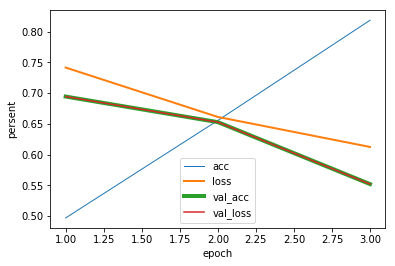

In [48]:
import matplotlib.pyplot as plt

x = np.linspace(1,3,3)
lines = plt.plot(x, acc, x, loss, x, val_acc, x, val_loss)
plt.setp(lines[0], linewidth=1)
plt.setp(lines[1], linewidth=2)
plt.setp(lines[2], linewidth=3)
plt.setp(lines[2], linewidth=4)
plt.xlabel("epoch")
plt.ylabel("persent")
plt.legend(("acc","loss","val_acc","val_loss"))
plt.show()

In [49]:
model.layers[1]

In [50]:
# test_data 
y_test = model.predict([vec_test_data], batch_size=1024, verbose=1)   # ->(1000, 6)

153164/153164 [==============================] - 598s 4ms/step


In [54]:
y_test

array([[ 0.99999547,  0.92239422,  0.99958783,  0.1934948 ,  0.98634934,
         0.70814669],
       [ 0.37247682,  0.40909505,  0.3679679 ,  0.41509241,  0.34866887,
         0.43134964],
       [ 0.34887213,  0.40799153,  0.38453138,  0.41025808,  0.34266198,
         0.44540566],
       ..., 
       [ 0.37804866,  0.41520289,  0.37866133,  0.41064742,  0.37390634,
         0.46482348],
       [ 0.33972353,  0.39041695,  0.37619966,  0.47134393,  0.36521405,
         0.4566921 ],
       [ 0.61343443,  0.46266419,  0.51645678,  0.40656155,  0.5149222 ,
         0.4582178 ]], dtype=float32)

In [39]:
with open('./y_test.csv','w') as f:
    for _ in y_test:
        f.write(str(_))
        f.write(' ')
        

In [52]:
# before submission, use whiole data seet, 
# submission:
sample_submission = pd.read_csv("./sample_submission.csv")
sample_submission[labels_list] = y_test


# write dataframe to .csv file: without index!
sample_submission.to_csv('%.4f_'%(bst_val_score) + STAMP + '.csv', index=False)

In [ ]:
'''
DataFrame.to_csv(path_or_buf=None, 
                 sep=', ', na_rep='', 
                 float_format=None, columns=None, 
                 header=True,       ## !!
                 index=True,        ## !!
                 index_label=None, 
                 mode='w', encoding=None, 
                 compression=None, quoting=None, 
                 quotechar='"', line_terminator='\n', 
                 chunksize=None, tupleize_cols=None, 
                 date_format=None, doublequote=True, 
                 escapechar=None, decimal='.')
'''

# Test area: 

In [1]:
import numpy as np

In [9]:
a = [_ for _ in np.arange(1,10,1)]
b = [i for i in np.arange(11,20,1)]
c = []

In [10]:
f = open('./tmp.csv','w')
count=0
for i, j in zip(a,b):
    f.write(str(i))
    f.write(' ')
    f.write(str(j))
    f.write('\n\n')
    count+=1
f.close()

In [ ]:
# operatin on each <key, value> in dict:
for i,j in dict.items():
    #do something...

In [5]:
import pandas as pd
import sys
## after applying clean function,
# read cleaned comment, only comment:
# add attribute name
data = pd.read_csv("./cleaned_train_comment.csv",names=["comment_text"])

# keep it in the memory,
## data.to_csv("./cleaned_train_comment.csv",index=False)

# read original file, replace "comment_text" with cleaned "comment_text"
sample = pd.read_csv("./train.csv")
sample["comment_text"] = data
# finally write it to file
sample.to_csv("./full_train_data.csv",index=False)



# get 1000 samples as train_1000.csv


In [4]:
import pandas as pd
import sys

train_path = sys.argv[1]          # cleaned comment
ori_train_path = sys.argv[2]          # original training data file
full_cleaned_path = sys.argv[3]   # file to store fully cleaned data 

def clean_comment(train_path):
    data = pd.read_csv(train_path, names=["comment_text"])

    sample = pd.read_csv(ori_train_path)
    sample["comment_text"] = data
    
    sample.to_csv(full_cleaned_path, index=False)
    

/media/junhui/DATA/text_analysis/kaggle


In [6]:
# choose 1000 piese of data:
data = pd.read_csv("aaaa.csv")
data_1000 = data.loc[0:1000,:]
data_1000.to_csv("./train_1000.csv",index=False)

In [11]:
data = pd.read_csv("aabb.csv")
data_100 = data.loc[0:100,:]
data_100.to_csv("./test_100.csv",index=False)